In [1]:
# Imports and Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import gensim.downloader as api
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Web Scraping
def getdata(url):
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
        'Accept-Language': 'en-US, en;q=0.5',
        'Referer': 'https://www.google.com',
        'Connection': 'keep-alive',
        'DNT': '1'
    }
    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        r.raise_for_status()
        return r.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

def search_trustpilot(company_name):
    search_url = f"https://www.google.com/search?q={company_name}+trustpilot+review"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(search_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    for link in soup.find_all('a'):
        href = link.get('href')
        if 'trustpilot.com' in href:
            actual_link = re.search(r'q=(.*?)&', href)
            if actual_link:
                return actual_link.group(1)
    return None

def extract_reviews(soup):
    Rating = [a.find('img').get('alt') for a in soup.find_all("div", {"class": "star-rating_starRating__4rrcf star-rating_medium__iN6Ty"}) if a.find('img')]
    R = []
    for rating in Rating:
        if rating.startswith("Rated"):
            numeric_rating = rating.split()[1]
            R.append(numeric_rating)

    customer_reviews = soup.find_all("div", class_="styles_reviewContent__0Q2Tg")
    cus_res = [review.find("h2", class_="typography_heading-s__f7029").text.strip() if review.find("h2", class_="typography_heading-s__f7029") else '' for review in customer_reviews]
    rev_res = [review.find("p", class_="typography_body-l__KUYFJ").text.strip() if review.find("p", class_="typography_body-l__KUYFJ") else '' for review in customer_reviews]
    des_res = [review.find("p", class_="typography_body-l__KUYFJ").text.strip() if review.find("p", class_="typography_body-l__KUYFJ") else '' for review in customer_reviews]

    data = {
        'Name': cus_res,
        'review': rev_res,
        'description': des_res,
        'rating': R
    }

    return pd.DataFrame(data)



In [3]:
# NLP and Sentiment Analysis
w2v_model = api.load('word2vec-google-news-300')

def show_opinion_with_embeddings(text):
    if not text or pd.isnull(text):
        return 0, "Neutral"

    stop_words = set(stopwords.words('english'))
    tokenized_text = sent_tokenize(text)
    add = 0
    count = 0

    for sent in tokenized_text:
        words = word_tokenize(sent)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        if not filtered_words:
            continue
        word_embeddings = [w2v_model[word] for word in filtered_words if word in w2v_model]
        if not word_embeddings:
            continue
        sent_embedding = np.mean(word_embeddings, axis=0)
        res = TextBlob(sent).sentiment.polarity
        add += res
        count += 1

    if count != 0:
        avg = add / count
        if avg > 0.01:
            opinion = "Positive"
        elif avg < -0.01:
            opinion = "Negative"
        else:
            opinion = "Neutral"
    else:
        avg = 0
        opinion = "Neutral"

    return round(avg, 2), opinion

def combined_sentiment(text, rating):
    text_sentiment, _ = show_opinion_with_embeddings(text)
    
    try:
        rating = float(rating)
    except ValueError:
        rating = 0.0
    
    combined_sentiment_score = text_sentiment * rating
    
    if combined_sentiment_score > 0.01:
        overall_opinion = "Positive"
    elif combined_sentiment_score < -0.01:
        overall_opinion = "Negative"
    else:
        overall_opinion = "Neutral"
    
    return round(combined_sentiment_score, 2), overall_opinion


In [4]:
# Recommendation Logic
def provide_recommendation(df):
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    sentiment_counts = df['combined_sentiment'].value_counts()

    if 'Negative' in sentiment_counts and sentiment_counts['Negative'] > sentiment_counts['Positive']:
        return "Overall sentiment is negative. The website is not recommended."
    elif 'Positive' in sentiment_counts and sentiment_counts['Positive'] > sentiment_counts['Negative']:
        return "Overall sentiment is positive. The website is recommended."
    else:
        return "Overall sentiment is neutral. No clear recommendation."

# Main Program
company_name = input("Enter the company or product name: ")
trustpilot_url = search_trustpilot(company_name)

if trustpilot_url:
    print(f"Found Trustpilot URL: {trustpilot_url}")
    soup = BeautifulSoup(getdata(trustpilot_url), 'html.parser')
    
    if soup:
        df = extract_reviews(soup)
        print("Successfully retrieved reviews!")
        
        df['combined_opinion'] = df.apply(lambda row: combined_sentiment(row['description'], row['rating']), axis=1)
        df[['combined_score', 'combined_sentiment']] = df.combined_opinion.apply(lambda x: pd.Series(x))

        recommendation = provide_recommendation(df)
        print("Recommendation:", recommendation)

        # Display DataFrame with reviews
        print(df.head())
    else:
        print("Failed to retrieve or parse the website data.")
else:
    print("No Trustpilot URL found for the company.")


Found Trustpilot URL: https://www.trustpilot.com/review/vivo.com
Successfully retrieved reviews!
Recommendation: Overall sentiment is positive. The website is recommended.
                                               Name  \
0              I recently bought a Vivo V30 in the…   
1            Average value for money phones at best   
2                             VIVO V27 6/128 Review   
3              Am enjoying my vivo Y53s for over a…   
4  VIVO X60 SERIES THE WORST FLAGSHIP PHONE EVER!!!   

                                              review  \
0  I recently bought a Vivo V30 in the Kenyan mar...   
1  One of the worst value for money smartphone co...   
2  I'm using VIVO V27 6/128 varient. The phone is...   
3  Am enjoying my vivo Y53s for over a year now w...   
4  Just tonight, after a series of email correspo...   

                                         description  rating  \
0  I recently bought a Vivo V30 in the Kenyan mar...       2   
1  One of the worst value for mo

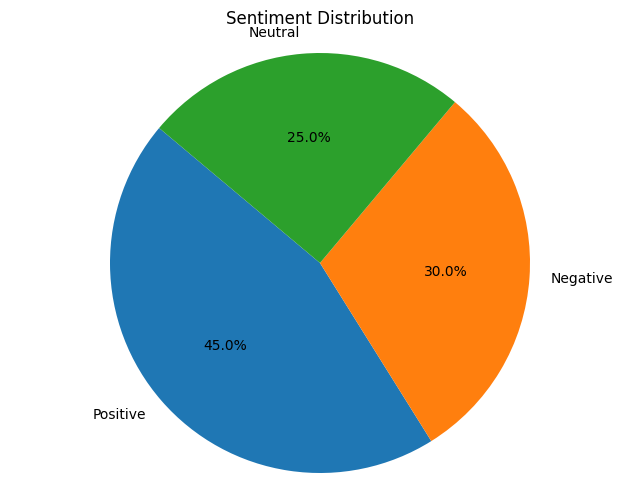

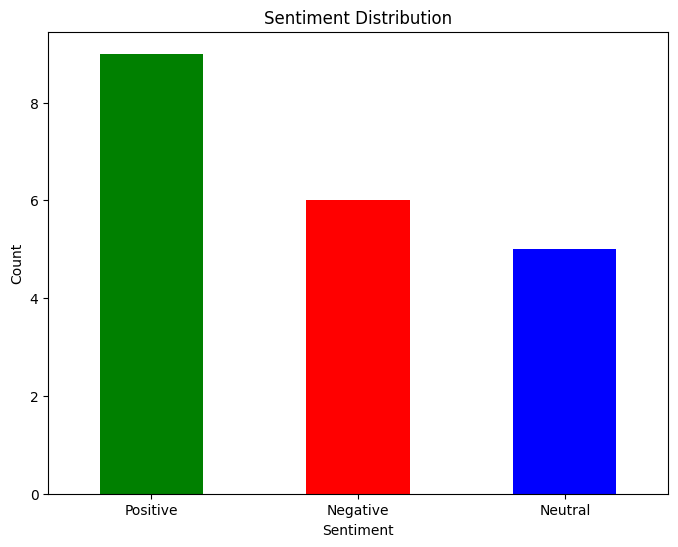

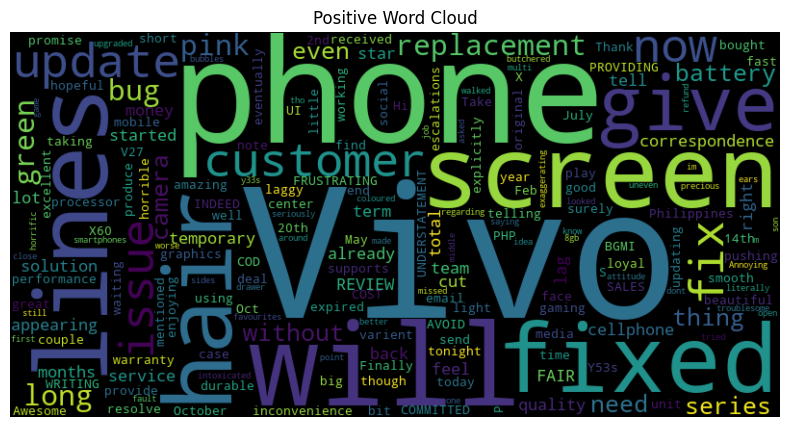

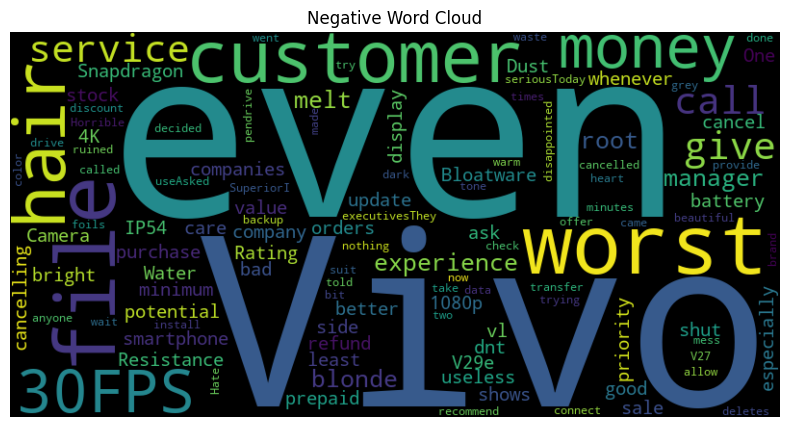

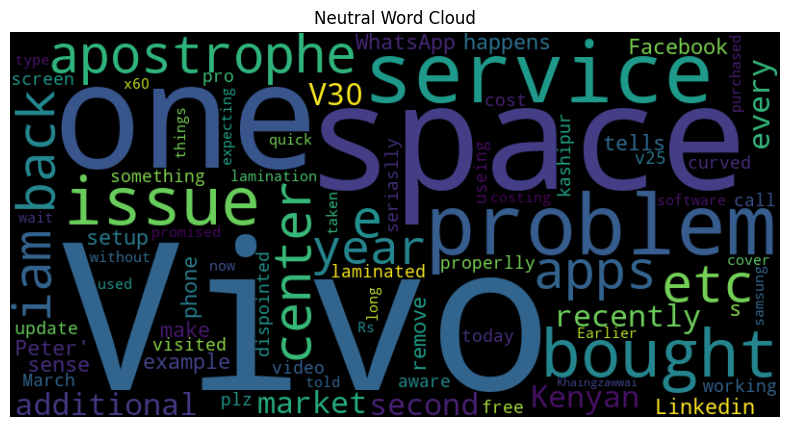

In [5]:
# Visualization
sentiment_counts = df['combined_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

# Bar graph for sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# WordCloud
positive_words = ' '.join(df[df['combined_sentiment'] == 'Positive']['description'])
negative_words = ' '.join(df[df['combined_sentiment'] == 'Negative']['description'])
neutral_words = ' '.join(df[df['combined_sentiment'] == 'Neutral']['description'])

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_words)
wordcloud_neutral = WordCloud(width=800, height=400).generate(neutral_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Word Cloud')
plt.axis('off')
plt.show()


In [6]:
if trustpilot_url:
    print(f"Found Trustpilot URL: {trustpilot_url}")
    soup = BeautifulSoup(getdata(trustpilot_url), 'html.parser')
    
    if soup:
        df = extract_reviews(soup)
        print("Successfully retrieved reviews!")
        
        df['combined_opinion'] = df.apply(lambda row: combined_sentiment(row['description'], row['rating']), axis=1)
        df[['combined_score', 'combined_sentiment']] = df.combined_opinion.apply(lambda x: pd.Series(x))

        recommendation = provide_recommendation(df)
        print("Recommendation:", recommendation)

    
    else:
        print("Failed to retrieve or parse the website data.")
else:
    print("No Trustpilot URL found for the company.")


Found Trustpilot URL: https://www.trustpilot.com/review/vivo.com
Successfully retrieved reviews!
Recommendation: Overall sentiment is positive. The website is recommended.
